# Assessing Forward/Backward Asymmetry in Stopping Powers
Our stopping power model predicts different stopping powers for particles traveling forward than those traveling backwards on some trajectories. The purpose of this notebook is to showcase why this is valid. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.features import LocalChargeDensity
import pandas as pd
import numpy as np
import pickle as pkl
import os

Configure parsl

In [2]:
import parsl
from parsl import *
#from parsl_config import config
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])
print("Parsl version : ", parsl.__version__)

Executors :  {0: <IPP Executor for site:Static_IPP>}
Parsl version :  0.3.1


## Load in the Tools
We'll need the trajectory computer, and the charge density so that we can make illustrative plots.

In [3]:
traj_computer = pkl.load(open('traj_computer.pkl', 'rb'))

In [4]:
charge_density = pkl.load(open(os.path.join('..', 'density_interp.pkl'), 'rb'))

## Simple Test: Channel
Here, we have a particle traveling forward or backwards along the channel of FCC Al

In [5]:
@App('python', dfk)
def compute_stopping_power(starting_point, direction, traj_computer=traj_computer):
    return traj_computer.compute_stopping_power(starting_point, direction, 1)

In [6]:
forward = compute_stopping_power([0,0.75,0.75], [1,0,0])

In [7]:
backward = compute_stopping_power([0,0.75,0.75], [-1,0,0])

In [8]:
%%time
forward = forward.result(); backward = backward.result()

Wall time: 19.3 s


In [9]:
print('Forward stopping power: ', forward[0])
print('Backward stopping power: ', backward[0])
print('Difference: ', backward[0]-forward[0])

Forward stopping power:  0.23861322613482033
Backward stopping power:  0.23860582406329936
Difference:  -7.402071520973275e-06


Consistent with my initial expectations, they are indeed the same (within numerical tolerances).

## Asymmetry: Along an Uneven Channel
In computing the stopping powers in the previous notebook, you will note that the shape lacks some symmetries one might expect: the particle moving in the $[4 1 1]$ direction does not equal the particle moving in the opposite, $[\bar{4} \bar{1} \bar{1}]$ direction.

In [10]:
direction = np.array([4,1,1])
starting_point = [0,0.75,0.85]

In [11]:
forward = compute_stopping_power(starting_point, direction)

In [12]:
backward = compute_stopping_power(starting_point, -direction)

In [13]:
%%time
forward = forward.result(); backward = backward.result()

Wall time: 9.21 s


In [14]:
print('Forward stopping power: ', forward[0])
print('Backward stopping power: ', backward[0])
print('Difference: ', backward[0]-forward[0])

Forward stopping power:  0.24530178893586002
Backward stopping power:  0.244253196699424
Difference:  -0.0010485922364360245


### Why is there an asymmetry?
Note that here is different: the stopping powers are *unequal*. For a long while, I thought this was a bug in the stopping power code. Then, after some thought, I noticed the forward and backward trajectory are indeed different. Starting from a common reference point - where the trajectories pass closest to an atom - we can observe that the two trajectories have a unique asymmetry.

In [15]:
# Find the point of nearest pass
forward_start = traj_computer._find_near_hits(starting_point, direction, 1)[0]
backward_start = traj_computer._find_near_hits(starting_point, -direction, 1)[0]

In [16]:
# Compute the features for 
@App('python', dfk)
def compute_features(starting_point, direction, offset, n_points, traj_computer=traj_computer):
    import numpy as np
    import pandas as pd
    X = np.linspace(offset, offset + 2, n_points)
    f = traj_computer._create_model_inputs(starting_point, direction, 1)
    features = [f(x) for x in X]
    labels = sum([f.feature_labels() for f in traj_computer.featurizers], [])
    return pd.DataFrame(dict(zip(labels, zip(*features))))

In [17]:
forward = compute_features(starting_point, direction, forward_start, 51)

In [18]:
backward = compute_features(starting_point, -direction, backward_start, 51)

In [19]:
%%time
forward = forward.result(); backward = backward.result();

Wall time: 3.06 s


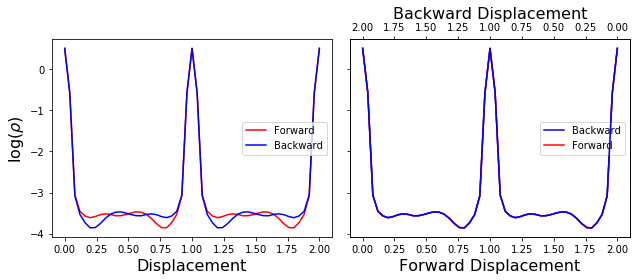

In [20]:
fig, ax = plt.subplots(1, 2, sharey=True)

x = np.linspace(0, 2, 51)
# Make the plot with both in same direction
ax[0].plot(x, forward['log density t=0.0'], 'r', label='Forward')
ax[0].plot(x, backward['log density t=0.0'], 'b', label='Backward')

ax[0].set_xlabel('Displacement', fontsize=16)
ax[0].set_ylabel('log($\\rho$)', fontsize=16)

ax[0].legend()

ax_top = ax[1].twiny()
ax[1].plot(x, forward['log density t=0.0'], 'b', label='Backward') # Is plotted over
ax[1].plot(x, forward['log density t=0.0'], 'r', label='Forward')
ax_top.plot(x, backward['log density t=0.0'], 'b', label='Backward')

ax[1].set_xlabel('Forward Displacement', fontsize=16)
ax_top.set_xlabel('Backward Displacement', fontsize=16)

ax_top.set_xlim(ax[1].get_xlim()[::-1])
ax[1].legend()

fig.set_size_inches(9, 4)
fig.tight_layout()

The above chart shows the electron charge density as a function of displacement along the trajectory. `0` is the starting point, `1` is where the pattern repeats itself, and we show two periods of this fnuction. First, as shown in the plot on the left, the forward direction has the lowest charge density just before it experiences the largest peak (when passing closest to an atom). In contrast, the backward direction experiences the lowest density immediately after the close pass to an atom. As shown in the plot on the right, the particles experience the same enviroments (the same charge density), but in reverse order. In short, the particles experience the same events in different orders and we find that this history matters.

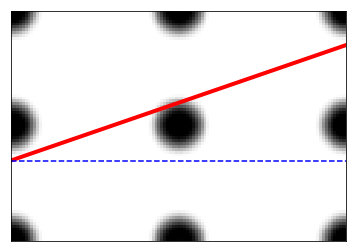

In [21]:
def make_trajectory_plot(ax, origin, vec1, vec2, x_dist, y_dist):
    # Compute the normal vectors
    unitvec1 = np.array(vec1) / np.linalg.norm(vec1)
    unitvec2 = np.array(vec2) / np.linalg.norm(vec2)
    
    # Make the grid
    x_spacing = np.linspace(0, x_dist, int(200 * x_dist / (x_dist + y_dist)))
    y_spacing = np.linspace(0, y_dist, int(200 * y_dist / (x_dist + y_dist)))
    xs, ys = np.meshgrid(x_spacing, y_spacing)
    points = np.array([i * unitvec1 + j * unitvec2 + origin for i,j in zip(xs.flatten(), ys.flatten())])
    points = (points / 4) % 1
    
    # Make the plots
    pct = ax.pcolor(xs, ys, np.log(charge_density(points).reshape(xs.shape)), vmin=-3, vmax=1, cmap='Greys')
    
    ax.set_xticks([])
    ax.set_yticks([])
    return pct

fig, ax = plt.subplots()

make_trajectory_plot(ax, [0,0,0], [1,0,0], [0,1,1], 2, 1 * np.sqrt(2))
ax.plot([0,2],[0.35 * np.sqrt(2), np.sqrt(2) * 0.85 ], 'r', lw=4)
ax.plot([0,2],[0.35 * np.sqrt(2), ] * 2, 'b--')
fig.set_size_inches(6, 3 * np.sqrt(2))

Another view of the asymmetry. The above plot shows the path of our particle in the $(01\bar{1})$ plane in the red, solid line. This path corresponds to one period of the function shown above. Note that a particle traveling forward (left-to-right) experiences two near passes between atoms - one closer than another - and two segments between atoms - one longer than another. It goes 'far pass'->'short distance'->'close pass'->'long distance'. The backward direction goes 'long distance'->'close pass'->'short distance'->'far pass'. The order of these events is different, which is the source of our asymmetry.

### Why was the original path symmetric?
The blue, dashed lines shows a hypothetical particle that starts slightly off the center of the $[100]$ channel, and follows the channel direction. This particle only experiences a single close pass to an atom, the forward and backward approaches are symmetric. Therefore, the stopping powers in each direction should be the same.

In [22]:
starting_point = [0, 0.75, 0.85]
direction = np.array([1, 0, 0])

In [23]:
forward = compute_stopping_power(starting_point, direction)

In [24]:
backward = compute_stopping_power(starting_point, -direction)

In [25]:
%%time
forward = forward.result(); backward = backward.result()

Wall time: 2 s


In [26]:
print('Forward stopping power: ', forward[0])
print('Backward stopping power: ', backward[0])
print('Difference: ', backward[0]-forward[0])

Forward stopping power:  0.2386798168222981
Backward stopping power:  0.23867241775894804
Difference:  -7.399063350066459e-06


And they are.

#### A harder example
In this section, we test a more complicated trajectory: the $[311]$ direction.

In [27]:
starting_point = [0, 0.75, 0.75]
direction = np.array([3, 1, 1])

In [28]:
forward = compute_stopping_power(starting_point, direction)

In [29]:
backward = compute_stopping_power(starting_point, -direction)

In [30]:
%%time
forward = forward.result(); backward = backward.result()

Wall time: 18.4 s


In [31]:
print('Forward stopping power: ', forward[0])
print('Backward stopping power: ', backward[0])
print('Difference: ', backward[0]-forward[0])

Forward stopping power:  0.24595176240063235
Backward stopping power:  0.24591382163714307
Difference:  -3.794076348928588e-05


As expected, the stopping powers are the same.

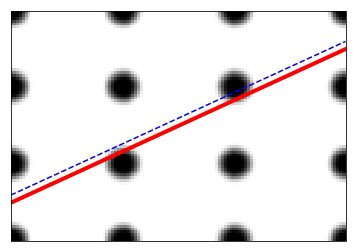

In [32]:
fig, ax = plt.subplots()

make_trajectory_plot(ax, [0,0,0], [1,0,0], [0,1,1], 3, 1.5 * np.sqrt(2))
ax.plot([0,3],[0.25 * np.sqrt(2), np.sqrt(2) * 1.25 ], 'r', lw=4)
ax.plot([0,3],[0.3 * np.sqrt(2), np.sqrt(2) * 1.3 ], 'b--')
fig.set_size_inches(6, 3 * np.sqrt(2))

The above plot shows one period of the $[311]$ trajectory in the solid, red line. Note that the forward and backwards directions are symmetric. If we bump the trajectory slightly up (blue, dashed line), we destroy the forward/backward symmetry (see below).

In [33]:
starting_point = [0, 0.75, 0.8]
direction = np.array([3, 1, 1])

In [34]:
forward = compute_stopping_power(starting_point, direction)

In [35]:
backward = compute_stopping_power(starting_point, -direction)

In [36]:
%%time
forward = forward.result(); backward = backward.result()

Wall time: 10.6 s


In [37]:
print('Forward stopping power: ', forward[0])
print('Backward stopping power: ', backward[0])
print('Difference: ', backward[0]-forward[0])

Forward stopping power:  0.24533156365585315
Backward stopping power:  0.24570863019827116
Difference:  0.00037706654241800863


The difference is present, but small because the perturbation from symmetrical is small.